# GEOS-Chem Curtain Plotting 

## Overview of this Notebook

* Import dependencies
* Load data
* Create a new dataset
* Define a function to plot altitude vs lat or lon, or zonal mean
* Plot data
* Save plots to a pdf

## Import dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from cartopy import crs
from cartopy.mpl.geoaxes import GeoAxes

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

# Also define colormap. Colormap file source: https://bitbucket.org/gcst/gcpy
rgb_WhGrYlRd = np.genfromtxt('/n/home08/elundgren/GC/python/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(rgb_WhGrYlRd/255.0)

## Load data

In [2]:
datafile = '/n/home05/msulprizio/SR1/runs/12.0.0/Run0/netcdf/GC_12.0.0.20160701.nc'
ds_orig = xr.open_dataset(datafile)
#ds_orig

In [3]:
# Look at the structure of concentration data array in the dataset
ds_orig['IJ_AVG_S__HNO3']

<xarray.DataArray 'IJ_AVG_S__HNO3' (time: 1, lev: 72, lat: 46, lon: 72)>
[238464 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2016-07-01
  * lev      (lev) float64 0.9925 0.9775 0.9624 0.9473 0.9322 0.9171 0.902 ...
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  HNO3 tracer
    units:      ppbv

## Create a new dataset

In [4]:
# Since I want to plot altitude not number of levels, define the altitude coords
# I will use info from the wiki to approximate:
#http://wiki.seas.harvard.edu/geos-chem/index.php/GEOS-Chem_vertical_grids#72-layer_vertical_grid
alts_rev = [78.146,74.594,71.812,69.440,67.243,65.115,63.004,60.902,58.816,56.752,54.717,52.716,50.754,48.835,46.962,45.134,43.355,41.627,39.951,38.328,36.759,35.244,33.782,32.372,31.015,29.701,28.423,27.180,25.971,24.794,23.648,22.531,21.438,20.364,19.309,18.269,17.243,16.222,15.198,14.170,13.134,12.086,11.021,9.936,8.846,7.943,7.237,6.585,5.980,5.413,4.879,4.375,3.896,3.439,3.074,2.792,2.517,2.249,1.988,1.759,1.584,1.436,1.290,1.146,1.004,0.864,0.726,0.589,0.454,0.320,0.189,0.058]
alts = alts_rev[::-1]

In [5]:
# For the other coordinates, use the coordinates in the original file
times=ds_orig['time']
lats=ds_orig['lat']
lons=ds_orig['lon']

In [6]:
# The first species I'm interested in is HNO3. Make a DataArray for it using altitudes
hno3arr = 0
hno3arr = ds_orig['IJ_AVG_S__HNO3'].data
da1 = xr.DataArray(hno3arr, 
                   coords={'time':times,'alt':alts,'lat':lats,'lon':lons},
                   dims=('time','alt','lat','lon'))
da1.attrs['units']='ppbv'
da1.name = 'HNO3'

In [7]:
# Next is PAN
panarr = 0
panarr = ds_orig['IJ_AVG_S__PAN'].data
da2 = xr.DataArray(panarr, 
                   coords={'time':times,'alt':alts,'lat':lats,'lon':lons},
                   dims=('time','alt','lat','lon'))
da2.attrs['units']='ppbv'
da2.name = 'PAN'

In [8]:
# Next is the sum of NO and NO2, which is not a single tracer in GEOS-Chem
noarr = 0
noarr = ds_orig['IJ_AVG_S__NO'].data  + ds_orig['IJ_AVG_S__NO2'].data
da3 = xr.DataArray(noarr, 
                   coords={'time':times,'alt':alts,'lat':lats,'lon':lons},
                   dims=('time','alt','lat','lon'))
da3.attrs['units']='ppbv'
da3.name = 'NO+NO2'

In [9]:
# Finally, NOy. This is the sum of a bunch of different species concentratins. I got this list
# from planeflight_mod.F in GEOS-Chem. 
# I suspect one of the species that goes into NOy is not in this data set. Check this:
[k for k in ds_orig.data_vars.keys() if 'PYPAN' in k]

[]

In [10]:
# It indeed is not present. Sum the rest only.
noyarr = 0
noyarr = ds_orig['IJ_AVG_S__NO'].data  + ds_orig['IJ_AVG_S__NO2'].data
noyarr = noyarr + ds_orig['IJ_AVG_S__NO3'].data  + ds_orig['IJ_AVG_S__HNO2'].data
noyarr = noyarr + ds_orig['IJ_AVG_S__HNO4'].data  + ds_orig['IJ_AVG_S__HNO3'].data
noyarr = noyarr + ds_orig['IJ_AVG_S__PAN'].data  + ds_orig['IJ_AVG_S__IPMN'].data
noyarr = noyarr + ds_orig['IJ_AVG_S__NPMN'].data  + ds_orig['IJ_AVG_S__PPN'].data
noyarr = noyarr + ds_orig['IJ_AVG_S__N2O5'].data
da4 = xr.DataArray(noyarr, 
                   coords={'time':times,'alt':alts,'lat':lats,'lon':lons},
                   dims=('time','alt','lat','lon'))
da4.attrs['units']='ppbv'
da4.name = 'NOy'

In [11]:
# Merge the four xarray DataArray containers into a single xarray Dataset
ds = xr.merge([da1,da2,da3,da4])
ds

<xarray.Dataset>
Dimensions:  (alt: 72, lat: 46, lon: 72, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-01
  * alt      (alt) float64 0.058 0.189 0.32 0.454 0.589 0.726 0.864 1.004 ...
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Data variables:
    HNO3     (time, alt, lat, lon) float32 5.55979e-07 5.55979e-07 ...
    PAN      (time, alt, lat, lon) float32 0.0100906 0.0100906 0.0100906 ...
    NO+NO2   (time, alt, lat, lon) float32 0.000621999 0.000621999 ...
    NOy      (time, alt, lat, lon) float32 0.0122359 0.0122359 0.0122359 ...

In [12]:
# Write this dataset to a netcdf file
ds.to_netcdf('/n/home08/elundgren/regal/nitrates.nc')

## Define a function to plot altitude vs lat or lon, or zonal mean

In [13]:
# Define a function plot altitude vs longitude (fixed lat), altitude vs latitude (fixed lon),
# or zonal mean
def plot_curtain(dgcc, varlist=None, itime=0, lonval=None, latval=None, zonalmean=False, 
                 savepdf=False, pdfname='./curtain.pdf', full_ratio_range=False):

    fixedlon = lonval != None
    fixedlat = latval != None
    
    # If no varlist is passed, plot all 3D variables in the dataset
    if varlist == None:
        varlist = [k for k in dgcc.data_vars.keys() if dgchp[k].ndim == 4]
        print('Plotting all 3D variables in dataset')
    n_var = len(varlist)
    
    # Some axes setup
    if fixedlon or zonalmean:
        xtick_positions = np.arange(-90,91,30) # latitudes
        xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    if fixedlat:
        xtick_positions = np.arange(-180,181,60) # longitudes
        xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    ytick_positions = np.arange(0,20,5) # altitudes (adjust as needed)
    yticklabels = [str(y) for y in ytick_positions]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {}'.format(pdfname))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        units = dgcc[varname].units
        
        # Set plot entent for axes
        if fixedlon or zonalmean:
            extent=(-90,90,0,20)
        if fixedlat:
            extent=(-180,180,0,20)
        
        # Slice the data in time
        ds = dgcc[varname].isel(time=itime)
        
        # Slice the data in space
        if fixedlon:
            gcc_curtain = ds.sel(lon=lonval) # if doing constant lon
        if fixedlat:
            gcc_curtain = ds.sel(lat=latval) # if doing constant lat
        if zonalmean:
            gcc_curtain = ds.mean(axis=1) # if doing zonal mean
            
        # Get min and max for colorbar limits
        [vmin, vmax] = [gcc_curtain.min(), gcc_curtain.max()]
        
        # Create 1x1 figure (leave as subplots for easy addition of more plots in figure)
        figs, ((ax0)) = plt.subplots(1, 1, figsize=[10,11], subplot_kw={'projection': crs.PlateCarree()})

        # Give the page a title
        offset = 0.96
        fontsize=25
        
        # Update title as needed (e.g. might want to remove or replace July)
        # Would be good to maybe pass an argument for this to function
        if fixedlon:
            if lonval >= 0:
                figs.suptitle('{}  July  ${}\degree$E'.format(varname,lonval), fontsize=fontsize, y=offset)
            else:
                figs.suptitle('{}  July  ${}\degree$W'.format(varname,-lonval), fontsize=fontsize, y=offset)
        if fixedlat:
            if latval >=0:
                figs.suptitle('{}  July  ${}\degree$N'.format(varname,latval), fontsize=fontsize, y=offset)
            else:
                figs.suptitle('{}  July  ${}\degree$S'.format(varname,-latval), fontsize=fontsize, y=offset)

        if zonalmean:
            figs.suptitle('{}  July  Zonal Mean'.format(varname), fontsize=fontsize, y=offset)
            
        # Plot 0
        # Update subtitle as needed (e.g. migh want to change source description)
        # Would be good to maybe pass as an argument to this function
        plot0 = ax0.imshow(gcc_curtain, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax0.set_title('GEOS-Chem 1-year Benchmark (12.0.0)', fontsize=20)
        ax0.set_aspect('auto')
        ax0.set_xticks(xtick_positions)
        ax0.set_xticklabels(xticklabels)
        ax0.set_yticks(ytick_positions)
        ax0.set_yticklabels(yticklabels)
        if fixedlon or zonalmean:
            ax0.set_xlabel('Latitude', fontsize=20)
        if fixedlat:
            ax0.set_xlabel('Longitude', fontsize=20)
        ax0.set_ylabel('Altitude (km)', fontsize=20)
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units, fontsize=12)
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

## Plot data

In [14]:
# Try a fixed longitude plot. 
# First, see what the options are for longitude
ds['lon']

<xarray.DataArray 'lon' (lon: 72)>
array([-180., -175., -170., -165., -160., -155., -150., -145., -140., -135.,
       -130., -125., -120., -115., -110., -105., -100.,  -95.,  -90.,  -85.,
        -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,  -45.,  -40.,  -35.,
        -30.,  -25.,  -20.,  -15.,  -10.,   -5.,    0.,    5.,   10.,   15.,
         20.,   25.,   30.,   35.,   40.,   45.,   50.,   55.,   60.,   65.,
         70.,   75.,   80.,   85.,   90.,   95.,  100.,  105.,  110.,  115.,
        120.,  125.,  130.,  135.,  140.,  145.,  150.,  155.,  160.,  165.,
        170.,  175.])
Coordinates:
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  Longitude
    units:      degrees_east
    axis:       X

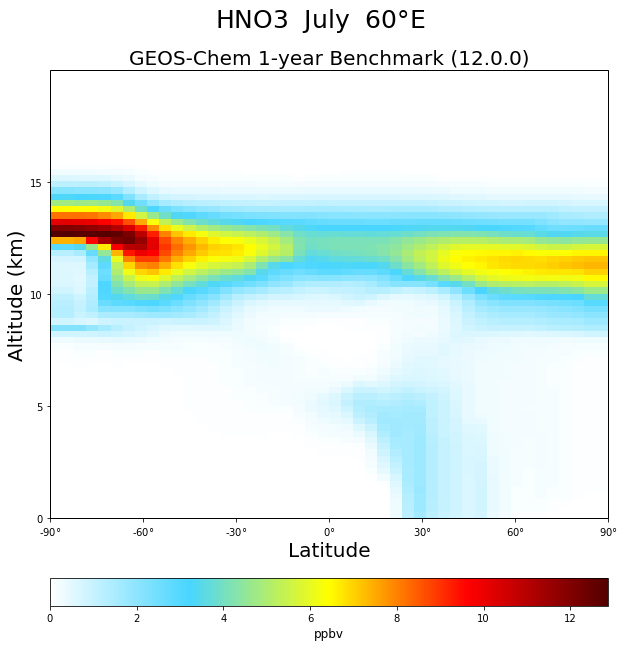

In [15]:
# Pick a longitude to plot
plot_curtain(ds, varlist=['HNO3'], lonval=60 )

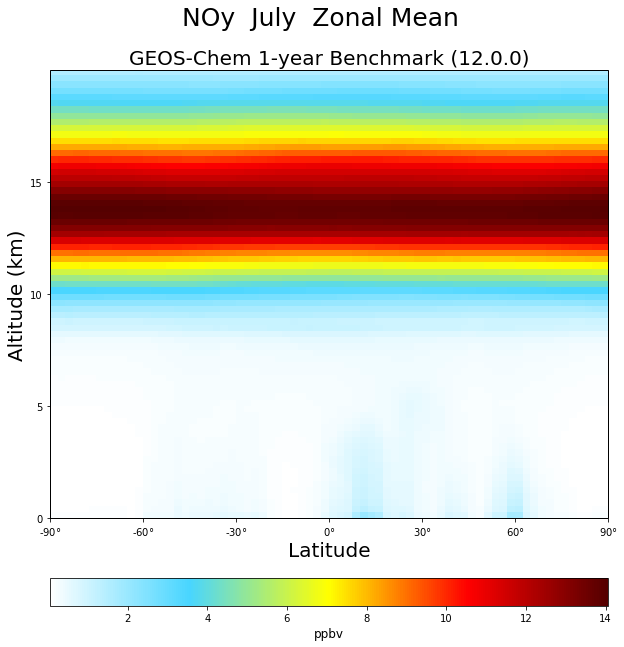

In [16]:
# Try a zonal mean plot
plot_curtain(ds, varlist=['NOy'], zonalmean=True )

In [17]:
# Try a fixed latitude plot
# First, see what my options are for latitudes
ds['lat']

<xarray.DataArray 'lat' (lat: 46)>
array([-89., -86., -82., -78., -74., -70., -66., -62., -58., -54., -50., -46.,
       -42., -38., -34., -30., -26., -22., -18., -14., -10.,  -6.,  -2.,   2.,
         6.,  10.,  14.,  18.,  22.,  26.,  30.,  34.,  38.,  42.,  46.,  50.,
        54.,  58.,  62.,  66.,  70.,  74.,  78.,  82.,  86.,  89.])
Coordinates:
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
Attributes:
    long_name:  Latitude
    units:      degrees_north
    axis:       Y

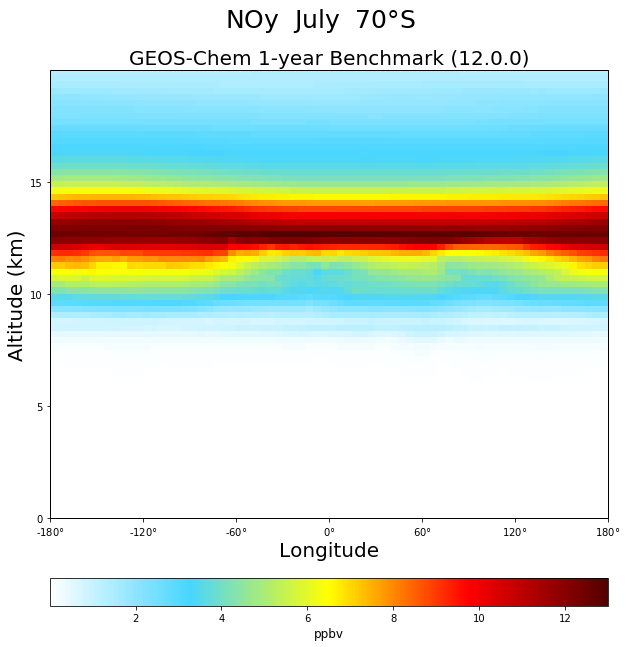

In [18]:
# Pick one latitude to plot
plot_curtain(ds, varlist=['NOy'], latval=-70 )

## Save plots to a pdf

In [19]:
# Since it looks okay, create plots for my four variables in the dataset and save it to a single pdf
varlist=['HNO3','PAN','NO+NO2','NOy']
pdfpath = '/n/home08/elundgren/regal/test.pdf'
plot_curtain(ds, varlist=varlist, lonval=60, savepdf=True, pdfname=pdfpath )


Creating /n/home08/elundgren/regal/test.pdf
0 1 2 3 